In [61]:
import sys
import matplotlib.pyplot as plt
import os
import torch
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
from tqdm import tqdm

sys.path.append('model')

In [62]:
from Models import Generator, Encoder
from Denormalization import SPADE, DenormResBlock
from utils.rois import RoI, gaussian_roi, squared_roi, mixture_roi
from utils.functions import generate_noise
from Data import Data

In [63]:
from config import noise_hyperparams

In [64]:
from scipy.signal import gaussian
import torch.nn.functional as F

In [65]:
def visualize_grid(gen_images, nrow=5, normalize=True):
    
    image = make_grid(gen_images, nrow=nrow, normalize=normalize).detach()
    image = image.permute(1, 2, 0).numpy()
    image = 255 * image
    image = image.astype(np.uint8)
    
    obj = Image.fromarray(image)
    
    return obj

In [67]:
data = Data('cats', [0.5] * 3, [0.5] * 3)

In [68]:
roi = RoI((64, 64), gaussian_roi, len(data))

In [69]:
gen_hyperparams = {'init_size': (8, 8),
                    'dest_size': (64, 64),
                    'scale': 1.5,
                    'input_channels': 128,
                    'kernel_size': 3
}

gen = Generator(**gen_hyperparams)

In [70]:
state = torch.load('cats-198.chkp', map_location=torch.device('cpu'))

from collections import OrderedDict
modified_weights = OrderedDict()
for x, y in zip(state['model'].keys(), state['model'].values()):
    if x[:7] == 'module.':
        modified_weights[x[7:]] = y
    else:
        modified_weights[x] = y
state['model'] = modified_weights
gen.load_state_dict(state['model'])

<All keys matched successfully>

In [71]:
idx = np.random.randint(0, len(data), size=25)

In [72]:
images = []
for i in idx:
    images.append(data[i])
    
images = torch.stack(images)

In [73]:
masks = []
for i in idx:
    masks.append(roi[i])
    
masks = torch.stack(masks).unsqueeze(1)

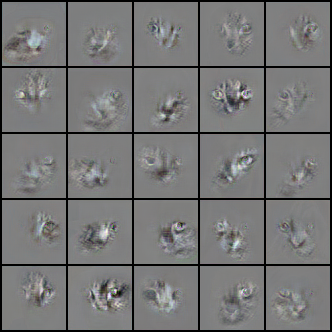

In [127]:
random_1 = generate_noise(25, **noise_hyperparams)
random_2 = generate_noise(25, **noise_hyperparams)

gen.eval()
gen_images_1 = gen((random_1, images, masks))[0]
gen_images_2 = gen((random_2, images, masks))[0]

difference = gen_images_1 - gen_images_2
visualize_grid(difference, nrow=5, normalize=True)

In [128]:
random = generate_noise(25, **noise_hyperparams)

In [14]:
def normalize(tensor, return_pil=True):
    
    tensor = tensor.detach().permute(1, 2, 0).numpy()
    #tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    tensor = tensor * 0.5 + 0.5
    tensor = (tensor * 255).astype(np.uint8)
    
    if return_pil:
        tensor = Image.fromarray(tensor)
    
    return tensor

def get_masked(image, gen, mask):
    
    image = normalize(image, return_pil=False)
    gen = normalize(gen, return_pil=False)
    
    mask = mask.permute(1, 2, 0).numpy().astype(np.uint8)
    
    output = mask * gen + (1-mask) * image
    output = Image.fromarray(output)
    
    return output

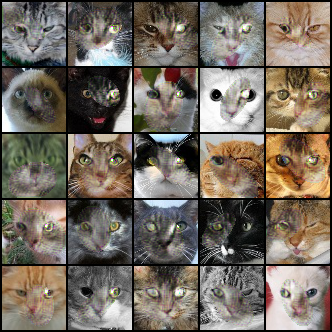

In [74]:
random = generate_noise(25, **noise_hyperparams)

gen.eval()
gen_images = gen((random, images, masks))[0]
#visualize_grid(gen_images, nrow=5, normalize=True)
visualize_grid(masks * gen_images + (1-masks) * images, nrow=5, normalize=True)

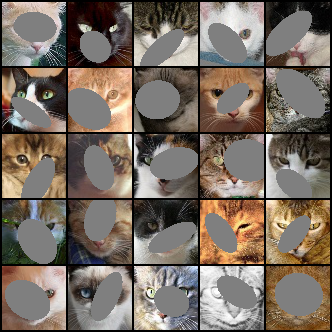

In [16]:
visualize_grid((1-masks) * images, nrow=5, normalize=True)

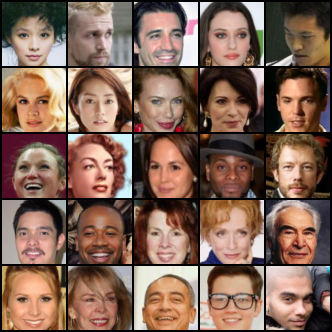

In [18]:
visualize_grid(images, nrow=5, normalize=True)

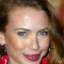

In [63]:
visualize_grid(images[7])

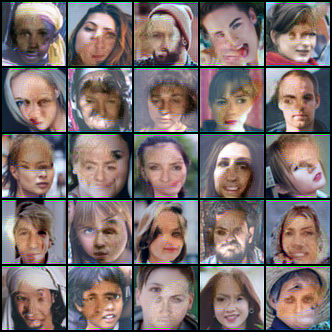

In [17]:
visualize_grid(gen_images, nrow=5, normalize=True)

In [37]:
visualize_grid(images * (1-masks), nrow=5, normalize=True).save('masked_cats.png')

In [89]:
visualize_grid(images, nrow=5, normalize=True).save('fully_generated.png')

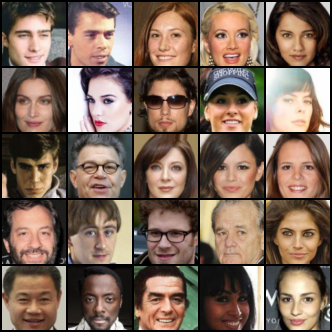

In [198]:
visualize_grid(images, nrow=5, normalize=True)

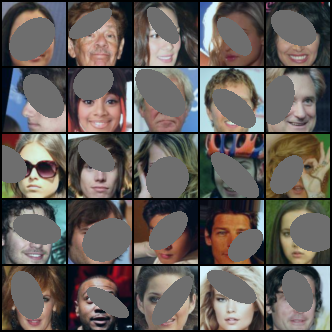

In [48]:
visualize_grid(images * (1-masks), nrow=5, normalize=True)

## Interactive

In [75]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [76]:
fixed_noise = torch.randn((1, noise_hyperparams['noise_dim']))

In [77]:
sliders_dict = {}

for i in range(noise_hyperparams['cont_dim']):
    
    name = 'Cont {}'.format(i+1)
    sliders_dict[name] = widgets.FloatSlider(value=0.1,
                                               min=-1.5,
                                               max=1.5,
                                               step=0.05)

for i in range(noise_hyperparams['n_disc']):
    
    name = 'Disc {}'.format(i+1)
    sliders_dict[name] = widgets.FloatSlider(value=0.0,
                                               min=0.0,
                                               max=noise_hyperparams['disc_dim']-1,
                                               step=1.0)

In [78]:
class Visualization(object):
    
    def __init__(self, generator, fixed_noise, image, mask, noise_hyperparams):
        
        self.gen = generator
        self.gen.eval()
        for params in self.gen.parameters():
            params.require_grad = False
            
        self.fixed_noise = fixed_noise
        self.image = image.unsqueeze(0)
        self.mask = mask.unsqueeze(0)
        
        self.n_disc = noise_hyperparams['disc_dim']
        self.identity = torch.eye(self.n_disc)
        
        self.n_cont = noise_hyperparams['noise_dim']
        
    def plot_controllability(self, **control):
        
        if self.fixed_noise is not None:
            noise = self.fixed_noise
        else:
            noise = torch.randn([1, self.n_cont])

        for key, value in control.items():

            if 'Cont' in key:

                add = torch.Tensor([[value]])
                noise = torch.cat([noise, add], axis=1)

            if 'Disc' in key:

                add = self.identity[int(value)].view(1, -1)
                noise = torch.cat([noise, add], axis=1)

        gen_image = self.gen((noise, self.image, self.mask))[0]
        output = get_masked(self.image[0], 
                            gen_image[0], 
                            self.mask[0])

        output = output.resize((256, 256), Image.ANTIALIAS)
        return output

In [79]:
class GroupedVisualization(object):
    
    def __init__(self, generator, fixed_noises, images, masks, noise_hyperparams):
        
        self.gen = generator
        self.gen.eval()
        for params in self.gen.parameters():
            params.require_grad = False
            
        self.fixed_noises = fixed_noises
        self.images = images
        self.masks = masks
        
        self.n_disc = noise_hyperparams['disc_dim']
        self.identity = torch.eye(self.n_disc)
        
        self.n_cont = noise_hyperparams['noise_dim']
        
        self.placeholder = 0
        
    def plot_controllability(self, **control):
        
        if self.fixed_noises is not None:
            noise = self.fixed_noises
        else:
            noise = torch.randn([self.images.size(0), self.n_cont])

        for key, value in control.items():

            if 'Cont' in key:

                add = torch.Tensor([[value]])
                add = add.repeat(self.images.size(0), 1)
                noise = torch.cat([noise, add], axis=1)

            if 'Disc' in key:

                add = self.identity[int(value)].view(1, -1)
                add = add.repeat(self.images.size(0), 1)
                noise = torch.cat([noise, add], axis=1)
        
        gen_images = self.gen((noise, self.images, self.masks))[0]
        
        output = visualize_grid(self.masks * gen_images + (1-self.masks) * self.images, nrow=2, normalize=True)
        output = output.resize((256, 256), Image.ANTIALIAS)
        
        self.placeholder = output
        
        return output

In [29]:
fixed_noise = None
obj = Visualization(gen, fixed_noise, images[22], masks[22], noise_hyperparams)

In [30]:
interact(obj.plot_controllability, **sliders_dict)

interactive(children=(FloatSlider(value=0.95, description='Cont 1', max=1.5, min=-1.5, step=0.05), FloatSlider…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [90]:
fixed_noise = None
obj = GroupedVisualization(gen, fixed_noise, images[12:16], masks[1:2].repeat(4, 1, 1, 1), noise_hyperparams)

In [91]:
interact(obj.plot_controllability, **sliders_dict)

interactive(children=(FloatSlider(value=0.1, description='Cont 1', max=1.5, min=-1.5, step=0.05), FloatSlider(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [102]:
obj.placeholder.save('control_vis_cats/8.png')

In [101]:
visualize_grid(images[12:16], nrow=2, normalize=True).save('control_vis_cats/real.png')